In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gitdb2
!pip install GitPython
!pip install -U albumentations --no-binary qudida,albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 19.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 173 kB 31.1 MB/s 
Skipping wheel build for albumentations, due to binaries being disabled for it.
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
    Running setup.py install for albumentations ... done


In [ ]:
%cd /content/drive/MyDrive/Robotics Final Project/semantic_segmentation

/content/drive/MyDrive/Robotics Final Project/semantic_segmentation


In [ ]:
%matplotlib inline

# module for working with operating system
import os

# module for fetching item from its operand
from operator import itemgetter

# math library
import math
# opencv library
import cv2
# computational library
import numpy as np
# pytorch imports
import torch
# import primitives to build our custom model
import torch.nn as nn
# optimizer
import torch.optim as optim
# visualization library
import matplotlib.pyplot as plt  # pylint: disable=unused-import
# model zoo with pretrained models
import torchvision.models as models
# some extended pytorch primitives
import torch.nn.functional as F

# pretty progress bar
from tqdm.auto import tqdm  # pylint: disable=unused-import
# augmentation imports
from albumentations import Compose, Normalize, RandomCrop, HorizontalFlip, ShiftScaleRotate, HueSaturationValue
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import MultiStepLR

# generic Trainer class imports
from trainer import Trainer, hooks
from trainer.utils import (  # pylint: disable=unused-import
    setup_system,
    patch_configs,
    download_git_folder,
    get_camvid_dataset_parameters,
    draw_semantic_segmentation_batch,
    draw_semantic_segmentation_samples,
    init_semantic_segmentation_dataset,
)
from trainer.base_metric import BaseMetric
from trainer.configuration import SystemConfig, DatasetConfig, TrainerConfig, OptimizerConfig, DataloaderConfig
from trainer.matplotlib_visualizer import MatplotlibVisualizer
from trainer.tensorboard_visualizer import TensorBoardVisualizer

In [ ]:
# dataset class implementation
class SemSegDataset(Dataset):
    def __init__(
        self,
        data_path,
        images_folder,
        masks_folder,
        num_classes,
        transforms=None,
        class_names=None,
        dataset_url=None,
        dataset_folder=None
    ):

        self.num_classes = num_classes
        self.transforms = transforms
        self.class_names = class_names
        # check whether dataset loading parameters exist
        if not os.path.isdir(data_path) and dataset_url is not None and dataset_folder is not None:
            # download CamVid dataset to the predefined directory
            download_git_folder(dataset_url, dataset_folder, data_path)
        # get the map of image-mask pairs
        self.dataset = init_semantic_segmentation_dataset(data_path, images_folder, masks_folder)

    def get_num_classes(self):
        return self.num_classes

    def get_class_name(self, idx):
        class_name = ""
        if self.class_names is not None and idx < len(self.num_classes):
            class_name = self.class_names[idx]
        return class_name

    # get dataset's length
    def __len__(self):
        return len(self.dataset)

    # get item by index
    def __getitem__(self, idx):
        sample = {
            "image": cv2.imread(self.dataset[idx+12]["image"])[..., ::-1],
            "mask": cv2.imread(self.dataset[idx+12]["mask"], 0)
        }
        # apply transforms to a sample
        if self.transforms is not None:
            sample = self.transforms(**sample)
            sample["mask"] = sample["mask"].long()
        return sample

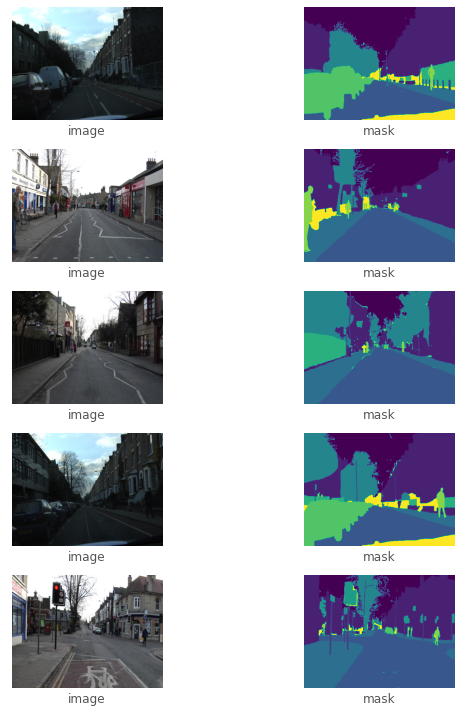

In [ ]:
# create test dataset
test_dataset = SemSegDataset(**get_camvid_dataset_parameters(
        data_path="data",
        dataset_type="test"
    ))
draw_semantic_segmentation_samples(test_dataset, n_samples=5)

In [ ]:
# create confusion matrix class
class ConfusionMatrix(BaseMetric):
normalized (bool): if normalized is True then confusion matrix will be normalized.
    def __init__(self, num_classes, normalized=False):
        # init confusion matrix class fields
        self.num_classes = num_classes
        self.normalized = normalized
        self.conf = np.ndarray((num_classes, num_classes), np.int32)
        self.reset()

    def reset(self):
        self.conf.fill(0)

    def update_value(self, pred, target):
        if torch.is_tensor(pred):
            # convert the prediction tensor to numpy array
            pred = pred.detach().cpu().numpy()
        if torch.is_tensor(target):
            # convert the target tensor to numpy array
            target = target.detach().cpu().numpy()

        # get rid of invalid indices
        valid_indices = np.where((target >= 0) & (target < self.num_classes))
        pred = pred[valid_indices]
        target = target[valid_indices]

        # calculate confusion matrix value for new predictions
        replace_indices = np.vstack((target.flatten(), pred.flatten())).T
        conf, _ = np.histogramdd(
            replace_indices,
            bins=(self.num_classes, self.num_classes),
            range=[(0, self.num_classes), (0, self.num_classes)]
        )
        # update confusion matrix value
        self.conf += conf.astype(np.int32)

    def get_metric_value(self):
        if self.normalized:
            conf = self.conf.astype(np.float32)
            # get normalized confusion matrix
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        return self.conf

In [ ]:
# create intersection over union class
class IntersectionOverUnion(BaseMetric):
    def __init__(self, num_classes, reduced_probs=False, normalized=False, ignore_indices=None):
        # created a normalized confusion matrix with num_classes
        self.conf_matrix = ConfusionMatrix(num_classes=num_classes, normalized=normalized)
        self.reduced_probs = reduced_probs

        # check whether ignored classes exist
        if ignore_indices is None:
            self.ignore_indices = None
        elif isinstance(ignore_indices, int):
            self.ignore_indices = (ignore_indices, )
        else:
            try:
                self.ignore_indices = tuple(ignore_indices)
            except TypeError:
                raise ValueError("'ignore_indices' must be an int or iterable")

    def reset(self):
        self.conf_matrix.reset()

    def update_value(self, pred, target):
        if not self.reduced_probs:
            pred = pred.argmax(dim=1)
        self.conf_matrix.update_value(pred, target)

    def get_metric_value(self):
        # get confusion matrix value
        conf_matrix = self.conf_matrix.get_metric_value()

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # set column values of ignore classes to 0
            conf_matrix[:, self.ignore_indices] = 0
            # set row values of ignore classes to 0
            conf_matrix[self.ignore_indices, :] = 0

        # get TP, FP and FN values
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # use errstate to handle the case of zero denominator value
        with np.errstate(divide='ignore', invalid='ignore'):
            # calculate iou by its formula
            iou = true_positive / (true_positive + false_positive + false_negative)

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # exclude ignore indices
            iou_valid_cls = np.delete(iou, self.ignore_indices)
            # get mean class iou value ignoring NaN values
            miou = np.nanmean(iou_valid_cls)
        else:
            # get mean class iou value ignoring NaN values
            miou = np.nanmean(iou)
        return {"mean_iou": miou, "iou": iou}

In [ ]:
# create intersection over union instance
metric = IntersectionOverUnion(num_classes=test_dataset.get_num_classes(), reduced_probs=True)
# add samples from test dataset and update metrics value
for sample in tqdm(test_dataset, ascii=False):
    masks = sample["mask"]
    metric.update_value(masks, masks)
# get the mean iou value
values = metric.get_metric_value()
print(values['mean_iou'])
print(values['iou'])

  0%|          | 0/232 [00:00<?, ?it/s]

1.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# create resnet encoder module
class ResNetEncoder(nn.Module):
    def __init__(self, resnet_type="resnet18", pretrained=True):
        super().__init__()
        # get PyTorch ResNet18 as feature extractor
        self.module = getattr(models, resnet_type)(pretrained=pretrained)

    # get output
    def get_channels_out(self):

        channels_out = []
        for layer in [getattr(self.module, "layer{}".format(i)) for i in range(1, 5)]:
            channels_out.append(self._get_block_size(layer))
        return channels_out[::-1]

    # define forward pass
    def forward(self, x):
        # init PyTorch ResNet18 layers
        # output number of channels = 64
        x = self.module.conv1(x)
        # output number of channels = 64
        x = self.module.bn1(x)
        # output number of channels = 64
        x = self.module.relu(x)
        # output number of channels = 64
        x = self.module.maxpool(x)

        # output number of channels = 64
        l1_output = self.module.layer1(x)
        # output number of channels = 128
        l2_output = self.module.layer2(l1_output)
        # output number of channels = 256
        l3_output = self.module.layer3(l2_output)
        # output number of channels = 512
        l4_output = self.module.layer4(l3_output)

        return l1_output, l2_output, l3_output, l4_output

    # get size of a module
    @staticmethod
    def _get_block_size(module):
        return list(module[-1].modules())[-2].weight.size()[0]

In [ ]:
# create connection layers between encoder and decoder blocks
class LateralConnection(nn.Module):

    def __init__(self, channels_in, channels_out):
        super().__init__()
        # create output number of channels from input
        self.proj = nn.Conv2d(channels_in, channels_out, kernel_size=1)

    # define forward pass
    def forward(self, prev, cur):
        # interpolating the previous feature map
        up = F.interpolate(prev, cur.size()[-2:], mode="nearest")
        # project consistent number of channels
        proj = self.proj(cur)
        # summarize feature maps into one
        return proj + up


# create decoder module
class FPNDecoder(nn.Module):

    def __init__(self, channels_in, channels_out=256):
        super().__init__()
        # init decoder as a list of modules
        self.module = nn.ModuleList()
        # create lateral connections between encoder and decoder blocks
        # for the last encoder block there is no need for upsampling
        self.module.append(nn.Conv2d(channels_in[0], channels_out, kernel_size=1))
        for i in range(1, len(channels_in)):
            self.module.append(LateralConnection(channels_in[i], channels_out))

    # define forward pass
    def forward(self, x):
        # append outputs after each laternl layer
        output = [self.module[0](x[0])]
        for i in range(1, len(x)):
            output.append(self.module[i](output[i - 1], x[i]))
        return output

In [ ]:
# create semantic segmentation model
class SemanticSegmentation(nn.Module):

    def __init__(self, num_classes, encoder_type=ResNetEncoder, channels_out=128, final_upsample=False):
        super().__init__()
        # init fields
        self.final_upsample = final_upsample
        self.encoder = encoder_type()
        # create decoder
        self.decoder = FPNDecoder(self.encoder.get_channels_out(), channels_out=channels_out)
        # create classifier with num_classes as output
        self.classifier = nn.Sequential(
            nn.Conv2d(channels_out, channels_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
            nn.Conv2d(channels_out, num_classes, kernel_size=1),
        )

    # define forward pass as a sequence of forward passes between all modules
    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder[::-1])
        classifier = self.classifier(decoder[-1])

        # upsample to the input image size if needed
        if self.final_upsample:
            classifier = F.interpolate(classifier, x.size()[-2:], mode="bilinear", align_corners=False)

        # output number of channels is equal to number of dataset classes
        return classifier

In [ ]:
# define experiment class
class Experiment:
    def __init__(
        self,
        # init configs
        system_config: SystemConfig = SystemConfig(),
        dataset_config: DatasetConfig = DatasetConfig(),
        dataloader_config: DataloaderConfig = DataloaderConfig(),
        optimizer_config: OptimizerConfig = OptimizerConfig(),
    ):
        # apply system settings
        self.system_config = system_config
        setup_system(system_config)
        # define train dataloader
        self.loader_train = DataLoader(
            # define our dataset
            SemSegDataset(
                **get_camvid_dataset_parameters(
                    data_path=dataset_config.root_dir,
                    dataset_type="train",
                    # define augmentations
                    transforms=Compose([
                        HorizontalFlip(),
                        ShiftScaleRotate(
                            shift_limit=0.0625,
                            scale_limit=0.50,
                            rotate_limit=45,
                            border_mode=cv2.BORDER_CONSTANT,
                            value=0,
                            mask_value=11,
                            p=.75
                        ),
                        HueSaturationValue(),
                        RandomCrop(height=352, width=480),
                        Normalize(),
                        ToTensorV2()
                    ])
                )
            ),
            batch_size=dataloader_config.batch_size,
            shuffle=True,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )

        # define test dataloader
        self.loader_test = DataLoader(
            SemSegDataset(
                **get_camvid_dataset_parameters(
                    data_path=dataset_config.root_dir,
                    dataset_type="test",
                    transforms=Compose([Normalize(), ToTensorV2()])
                )
            ),
            batch_size=dataloader_config.batch_size,
            sampler=12,
            shuffle=True,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )

        # define model
        self.model = SemanticSegmentation(
            num_classes=self.loader_test.dataset.get_num_classes(), final_upsample=True
        )
        # define loss function as cross-entropy loss
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=self.loader_test.dataset.get_num_classes())
        # define metrics function as intersection over union
        self.metric_fn = IntersectionOverUnion(
            num_classes=self.loader_test.dataset.get_num_classes(), reduced_probs=False
        )
        # define optimizer and its params
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay
        )
        # define learning rate scheduler
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        # define visualizer
        # self.visualizer = MatplotlibVisualizer()
        self.visualizer = TensorBoardVisualizer()

    # run training
    def run(self, trainer_config: TrainerConfig) -> dict:
        # apply system settings
        setup_system(self.system_config)
        # move training to the chosen device
        device = torch.device(trainer_config.device)
        # send data to chosen device
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.to(device)

        # define trainer
        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            data_getter=itemgetter("image"),
            target_getter=itemgetter("mask"),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("mean_iou"),
            visualizer=self.visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir
        )

        # define hook to run after each epoch
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_semseg)
        # run the training
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

In [ ]:
# run the experiment
dataloader_config, trainer_config = patch_configs(epoch_num_to_set=10, batch_size_to_set=16, )

optimizer_config = OptimizerConfig(learning_rate= 0.001, lr_step_milestones =[], weight_decay=4e-5)
experiment = Experiment(dataloader_config=dataloader_config, optimizer_config=optimizer_config)
metrics = experiment.run(trainer_config)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also u

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b9777b1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b9777b1f0>
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
        if w.is_alive():
self._shutdown_workers()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError  File "/usr/lib/python3.8/multiprocessing/process.py"

  0%|          | 0/23 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b9777b1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b9777b1f0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b9777b1f0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", l

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b9777b1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7b9777b1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
def plot_metrics(num_classes, metrics):
    plt.rcParams['figure.figsize'] = (20,15)
    plt.style.use('ggplot')
    plt.figure()
    num_cols = 3
    num_rows = math.ceil(num_classes/num_cols)

    ious = {}
    for i in range(num_classes):
        ious["test_"+str(i)]=[]

    for metric_iou in metrics['test_metric']:
        for idx, iou in enumerate(metric_iou['iou']):
            ious["test_"+str(idx)].append(iou)
    
    for id, (iou_cls, iou) in enumerate(ious.items()):
        plt.subplot(num_rows, num_cols, id+1)
        plt.plot(metrics['epoch'], iou, label='train_loss')
        
        plt.xlabel('Epochs')
        plt.ylabel(iou_cls)     

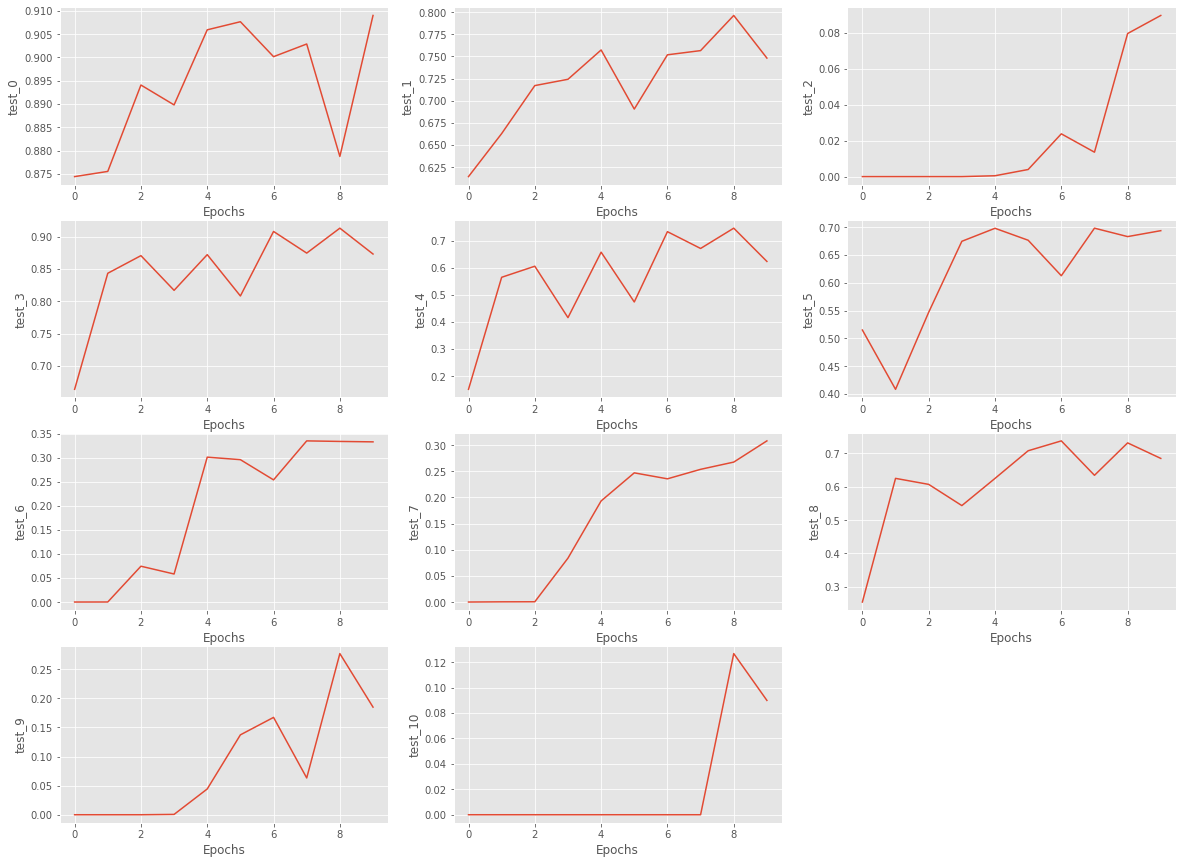

In [ ]:
plot_metrics(experiment.loader_test.dataset.get_num_classes(), metrics)

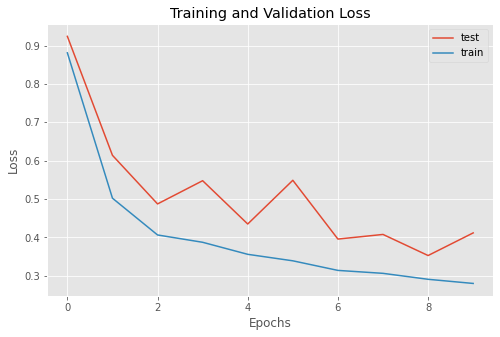

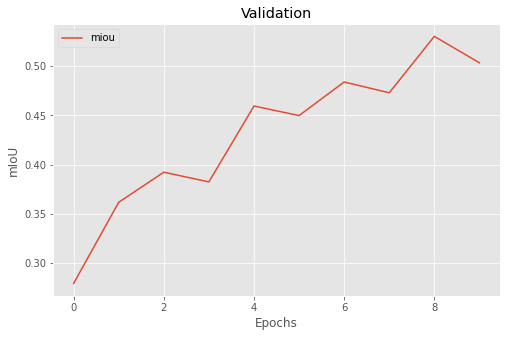

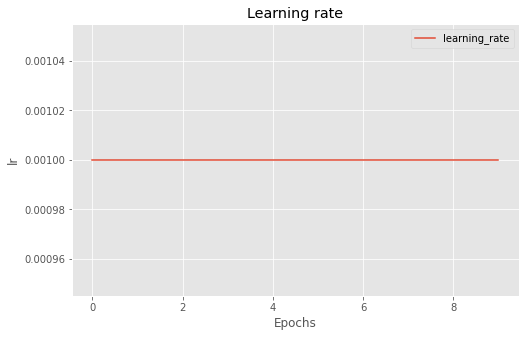

In [ ]:
plt.rcParams['figure.figsize'] = (8,5)
plt.style.use('ggplot')

# create new figure
plt.figure()
# plot test and train loss
plt.plot(metrics["test_loss"], label="test")
plt.plot(metrics["train_loss"], label="train")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# create new figure
plt.figure()
# plot mean iou metric for all classes
plt.plot([metric['mean_iou'] for metric in metrics["test_metric"]], label="miou")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.title('Validation')

# create new figure
plt.figure()
# plot learning rate
plt.plot(metrics['learning_rate'], label="learning_rate")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.title('Learning rate')

plt.show()

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


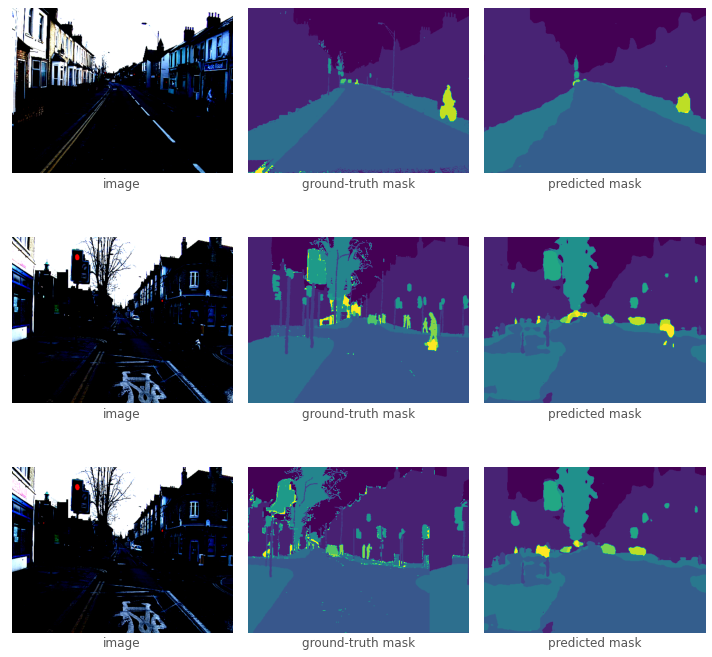

In [ ]:
# get test samples
sample = next(iter(experiment.loader_test))

# get device to run the training on
device = torch.device(trainer_config.device)
# put images on the chosen device
images = sample["image"].to(device)
# get predictions
preds = experiment.model(images).softmax(dim=1).argmax(dim=1)
# visualize the results
draw_semantic_segmentation_batch(images, sample["mask"], preds)